This notebook is for building CNN models and checking which configuration gives the best accuracy in scenery identification.

Data source : https://www.kaggle.com/puneet6060/intel-image-classification

In [1]:
import tensorflow as tf
import pandas as pd
import matplotlib.pyplot as plt
%matplotlib inline
import numpy as np

from sklearn.metrics import classification_report

Read in train and validation and test images.

In [2]:
image_path = "../input/intel-image-classification/seg_train/seg_train"
train_ds = tf.keras.preprocessing.image_dataset_from_directory(
  image_path,
  image_size=(224,224),
  batch_size=32,
validation_split=0.25,
  subset="training",
  seed=123)


val_ds = tf.keras.preprocessing.image_dataset_from_directory(
  image_path,
  image_size=(224,224),
  batch_size=32,
validation_split=0.25,
  subset="validation",
  seed=123)

test_path = "../input/intel-image-classification/seg_test/seg_test"
test_ds = tf.keras.preprocessing.image_dataset_from_directory(
  test_path,
  image_size=(224,224),
  batch_size=32)



Found 14034 files belonging to 6 classes.
Using 10526 files for training.
Found 14034 files belonging to 6 classes.
Using 3508 files for validation.
Found 3000 files belonging to 6 classes.


Get class names.

In [4]:
import glob
import pathlib 

data_dir = pathlib.Path(image_path)
class_names = np.array(sorted([item.name for item in data_dir.glob('*') if item.name != "LICENSE.txt"]))
print(class_names)

['buildings' 'forest' 'glacier' 'mountain' 'sea' 'street']


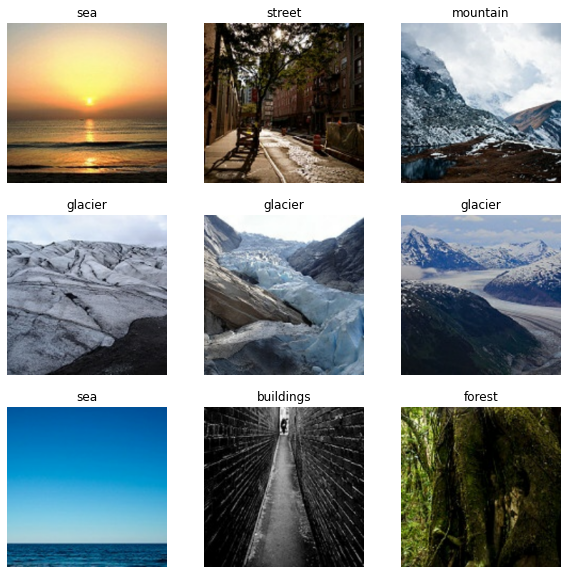

In [5]:
## visualize train set images
image_batch, label_batch = next(iter(train_ds))
plt.figure(figsize=(10, 10))
for i in range(9):
    ax = plt.subplot(3, 3, i + 1)
    plt.imshow(image_batch[i].numpy().astype("uint8"))
    label = label_batch[i]
    name = class_names[label]
    plt.title(name)
    plt.axis("off")

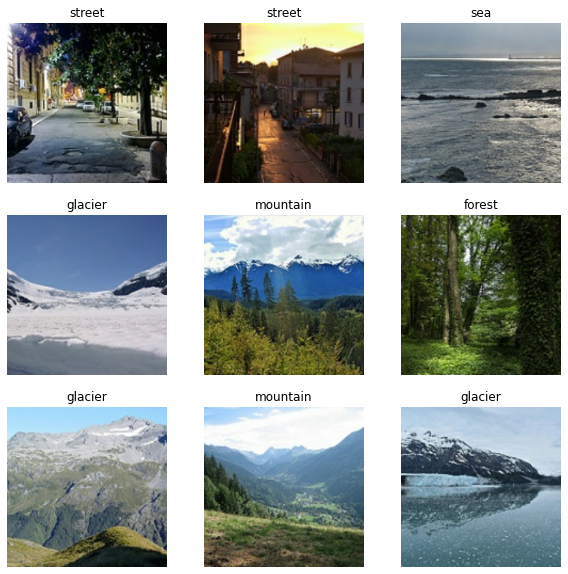

In [6]:
## visualize validation images 
image_batch, label_batch = next(iter(val_ds))
plt.figure(figsize=(10, 10))
for i in range(9):
    ax = plt.subplot(3, 3, i + 1)
    plt.imshow(image_batch[i].numpy().astype("uint8"))
    label = label_batch[i]
    name = class_names[label]
    plt.title(name)
    plt.axis("off")

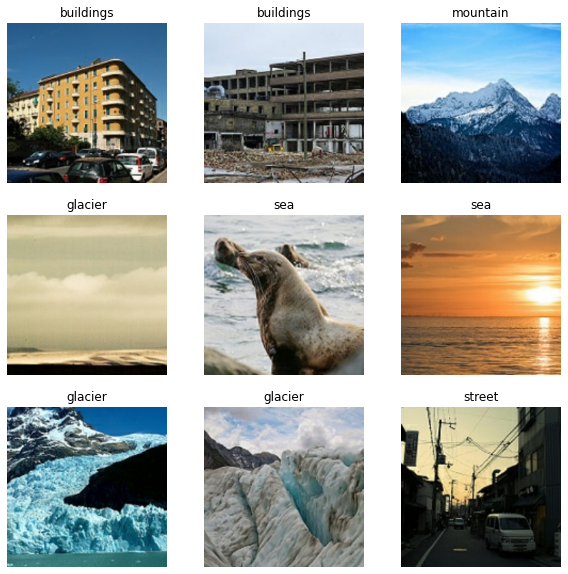

In [7]:
## visualize test images 
image_batch, label_batch = next(iter(test_ds))
plt.figure(figsize=(10, 10))
for i in range(9):
    ax = plt.subplot(3, 3, i + 1)
    plt.imshow(image_batch[i].numpy().astype("uint8"))
    label = label_batch[i]
    name = class_names[label]
    plt.title(name)
    plt.axis("off")

Read in images for predicting the classes.  

In [8]:
import cv2
import os

def load_images_from_folder(folder):
    images = []
    for filename in os.listdir(folder):
        img = cv2.imread(os.path.join(folder,filename))
        img = cv2.resize(img , (224,224))
        if img is not None:
            images.append(img)
    return images

pred_images = load_images_from_folder("../input/intel-image-classification/seg_pred/seg_pred")

In [9]:
type(pred_images)

list

In [10]:
pred_images = np.array(pred_images)
pred_images.shape

(7301, 224, 224, 3)

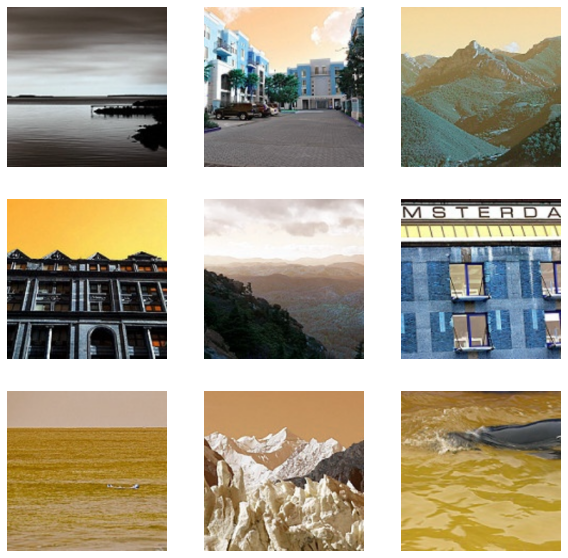

In [11]:
## visualize prediction images 
plt.figure(figsize=(10, 10))
for i in range(9):
    ax = plt.subplot(3, 3, i + 1)
    plt.imshow(pred_images[i])
    plt.axis("off")

Epoch 1/10
329/329 [==============================] - 1159s 4s/step - loss: 72.6054 - accuracy: 0.2440 - val_loss: 1.7715 - val_accuracy: 0.2166
Epoch 2/10
329/329 [==============================] - 1097s 3s/step - loss: 1.5318 - accuracy: 0.3931 - val_loss: 1.2531 - val_accuracy: 0.5165
Epoch 3/10
329/329 [==============================] - 1099s 3s/step - loss: 1.1087 - accuracy: 0.5621 - val_loss: 0.9786 - val_accuracy: 0.6140
Epoch 4/10
329/329 [==============================] - 1080s 3s/step - loss: 1.0212 - accuracy: 0.6024 - val_loss: 0.9167 - val_accuracy: 0.6383
Epoch 5/10
329/329 [==============================] - 1095s 3s/step - loss: 0.8734 - accuracy: 0.6679 - val_loss: 0.9171 - val_accuracy: 0.6594
Epoch 6/10
329/329 [==============================] - 1091s 3s/step - loss: 0.7679 - accuracy: 0.7016 - val_loss: 0.8602 - val_accuracy: 0.6742
Epoch 7/10
329/329 [==============================] - 1099s 3s/step - loss: 0.6485 - accuracy: 0.7497 - val_loss: 0.8991 - val_accuracy

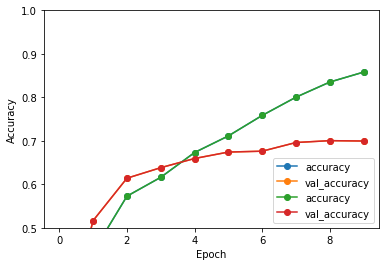

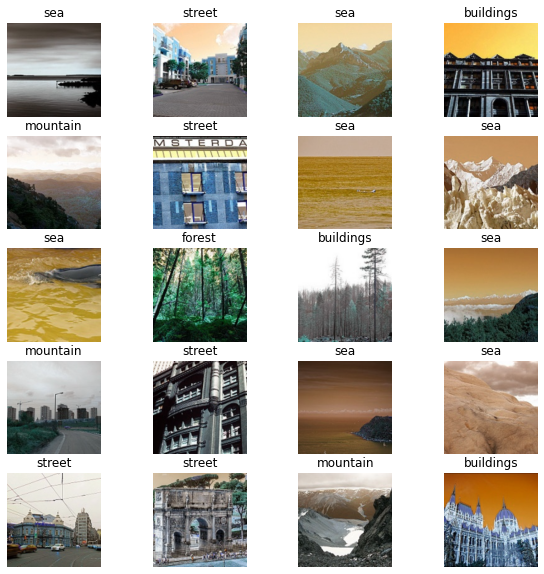

In [15]:
## three  layer CNN 

##
model = tf.keras.models.Sequential([
    tf.keras.layers.Conv2D( activation='relu', input_shape=(224, 224, 3),padding = 'same', filters = 64, kernel_size = 3),
    tf.keras.layers.MaxPooling2D(pool_size = (2,2), strides = (2, 2)), 
    tf.keras.layers.Dropout(0.2),
    tf.keras.layers.Conv2D( activation='relu', padding = 'same', filters = 64, kernel_size = 3),
    tf.keras.layers.MaxPooling2D(pool_size = (2,2), strides = (2, 2)), 
    tf.keras.layers.Dropout(0.2),
    tf.keras.layers.Conv2D( activation='relu', padding = 'same', filters = 128, kernel_size = 3),
    tf.keras.layers.MaxPooling2D(pool_size = (2,2), strides = (2, 2)), 
    tf.keras.layers.Dropout(0.2),
tf.keras.layers.Flatten(),
tf.keras.layers.Dense(128, activation=tf.nn.relu),
tf.keras.layers.Dense(6, activation=tf.nn.softmax)])


model.compile(optimizer='adam', loss='sparse_categorical_crossentropy', metrics=['accuracy'], )
%time history = model.fit(train_ds, epochs=10, validation_data = val_ds)
##
test_loss, test_acc = model.evaluate(test_ds)
print("Test image accuracy :{}".format(test_acc))
##
plt.plot(history.history['accuracy'], '-o' ,label='accuracy')
plt.plot(history.history['val_accuracy'], '-o', label = 'val_accuracy')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.ylim([0.5, 1])
plt.legend(loc='lower right')
##
model.save('model_cnn3')
##
plt.plot(history.history['accuracy'], '-o' ,label='accuracy')
plt.plot(history.history['val_accuracy'], '-o', label = 'val_accuracy')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.ylim([0.5, 1])
plt.legend(loc='lower right')
##
##
## forctestdata set , check the classification report.
val_pred = np.array([])
val_labels = np.array([])
for x, y in test_ds:
    predictions =  np.argmax(model.predict(x), axis = -1)
    val_pred = np.concatenate([val_pred,np.array(predictions)])
    val_labels = np.concatenate([val_labels , y.numpy()])
    
##
print('Classification Report')
target_names = class_names
print(classification_report(val_labels, val_pred, target_names=class_names))
##
print(model.summary())
##
pred_images_prediction = model.predict(pred_images)
##
pred_images_class = []
for i in range(len(pred_images_prediction)):
    pred_images_class.append(np.argmax(pred_images_prediction[i], axis = -1))
##
## visualize prediction images with the prediction 
plt.figure(figsize=(10, 10))
for i in range(20):
    ax = plt.subplot(5, 4, i + 1)
    plt.imshow(pred_images[i])
    plt.title(class_names[pred_images_class[i]])
    plt.axis("off")

'Forest' has higher precision , while 'street' has higher recall.  


Epoch 1/10
329/329 [==============================] - 164s 477ms/step - loss: 1.5224 - accuracy: 0.4691 - val_loss: 0.9341 - val_accuracy: 0.6511
Epoch 2/10
329/329 [==============================] - 116s 351ms/step - loss: 0.8271 - accuracy: 0.6807 - val_loss: 0.7486 - val_accuracy: 0.7107
Epoch 3/10
329/329 [==============================] - 115s 350ms/step - loss: 0.6438 - accuracy: 0.7618 - val_loss: 0.6561 - val_accuracy: 0.7566
Epoch 4/10
329/329 [==============================] - 116s 350ms/step - loss: 0.5064 - accuracy: 0.8154 - val_loss: 0.5958 - val_accuracy: 0.7985
Epoch 5/10
329/329 [==============================] - 116s 352ms/step - loss: 0.3375 - accuracy: 0.8764 - val_loss: 0.6851 - val_accuracy: 0.7902
Epoch 6/10
329/329 [==============================] - 116s 351ms/step - loss: 0.2577 - accuracy: 0.9084 - val_loss: 0.7613 - val_accuracy: 0.7879
Epoch 7/10
329/329 [==============================] - 116s 350ms/step - loss: 0.1934 - accuracy: 0.9300 - val_loss: 0.8422 -

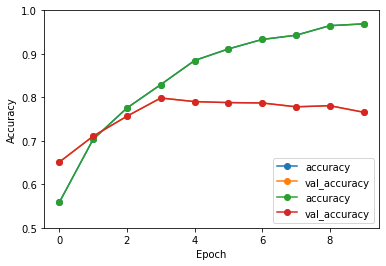

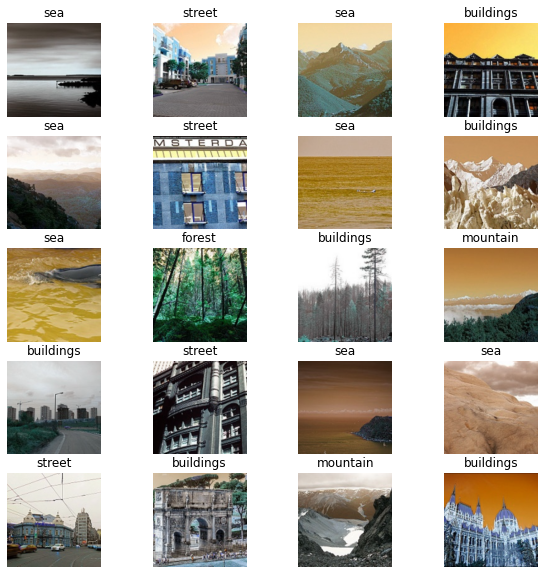

In [12]:
## three  layer CNN with scaled input .

##
model = tf.keras.models.Sequential([
    tf.keras.layers.experimental.preprocessing.Rescaling(1./255),
    tf.keras.layers.Conv2D( activation='relu', input_shape=(224, 224, 3),padding = 'same', filters = 64, kernel_size = 3),
    tf.keras.layers.MaxPooling2D(pool_size = (2,2), strides = (2, 2)), 
    tf.keras.layers.Dropout(0.2),
    tf.keras.layers.Conv2D( activation='relu', padding = 'same', filters = 64, kernel_size = 3),
    tf.keras.layers.MaxPooling2D(pool_size = (2,2), strides = (2, 2)), 
    tf.keras.layers.Dropout(0.2),
    tf.keras.layers.Conv2D( activation='relu', padding = 'same', filters = 128, kernel_size = 3),
    tf.keras.layers.MaxPooling2D(pool_size = (2,2), strides = (2, 2)), 
    tf.keras.layers.Dropout(0.2),
tf.keras.layers.Flatten(),
tf.keras.layers.Dense(128, activation=tf.nn.relu),
tf.keras.layers.Dense(6, activation=tf.nn.softmax)])


model.compile(optimizer='adam', loss='sparse_categorical_crossentropy', metrics=['accuracy'], )
%time history = model.fit(train_ds, epochs=10, validation_data = val_ds)
##
test_loss, test_acc = model.evaluate(test_ds)
print("Test image accuracy :{}".format(test_acc))
##
plt.plot(history.history['accuracy'], '-o' ,label='accuracy')
plt.plot(history.history['val_accuracy'], '-o', label = 'val_accuracy')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.ylim([0.5, 1])
plt.legend(loc='lower right')
##
model.save('model_cnn3')
##
plt.plot(history.history['accuracy'], '-o' ,label='accuracy')
plt.plot(history.history['val_accuracy'], '-o', label = 'val_accuracy')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.ylim([0.5, 1])
plt.legend(loc='lower right')
##
model.save('model_cnn2')
##
## for validation data set , check the classification report.
val_pred = np.array([])
val_labels = np.array([])
for x, y in test_ds:
    predictions =  np.argmax(model.predict(x), axis = -1)
    val_pred = np.concatenate([val_pred,np.array(predictions)])
    val_labels = np.concatenate([val_labels , y.numpy()])
    
##
print('Classification Report')
target_names = class_names
print(classification_report(val_labels, val_pred, target_names=class_names))
##
print(model.summary())
##
pred_images_prediction = model.predict(pred_images)
##
pred_images_class = []
for i in range(len(pred_images_prediction)):
    pred_images_class.append(np.argmax(pred_images_prediction[i], axis = -1))
##
## visualize prediction images with the prediction 
plt.figure(figsize=(10, 10))
for i in range(20):
    ax = plt.subplot(5, 4, i + 1)
    plt.imshow(pred_images[i])
    plt.title(class_names[pred_images_class[i]])
    plt.axis("off")

Model accuracy has increased from 0.69 to 0.77 with scaling.  
"Forest" has the best F1 score followed by "street".  

Epoch 1/10
329/329 [==============================] - 141s 424ms/step - loss: 1.5759 - accuracy: 0.4350 - val_loss: 0.8915 - val_accuracy: 0.6616
Epoch 2/10
329/329 [==============================] - 139s 421ms/step - loss: 0.8523 - accuracy: 0.6717 - val_loss: 0.7386 - val_accuracy: 0.7275
Epoch 3/10
329/329 [==============================] - 139s 421ms/step - loss: 0.6958 - accuracy: 0.7342 - val_loss: 0.6172 - val_accuracy: 0.7728
Epoch 4/10
329/329 [==============================] - 139s 420ms/step - loss: 0.6009 - accuracy: 0.7830 - val_loss: 0.5813 - val_accuracy: 0.7819
Epoch 5/10
329/329 [==============================] - 139s 422ms/step - loss: 0.5059 - accuracy: 0.8143 - val_loss: 0.5605 - val_accuracy: 0.7876
Epoch 6/10
329/329 [==============================] - 138s 420ms/step - loss: 0.4299 - accuracy: 0.8413 - val_loss: 0.5525 - val_accuracy: 0.7996
Epoch 7/10
329/329 [==============================] - 139s 420ms/step - loss: 0.3490 - accuracy: 0.8747 - val_loss: 0.5344 -

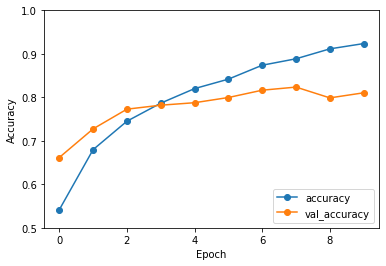

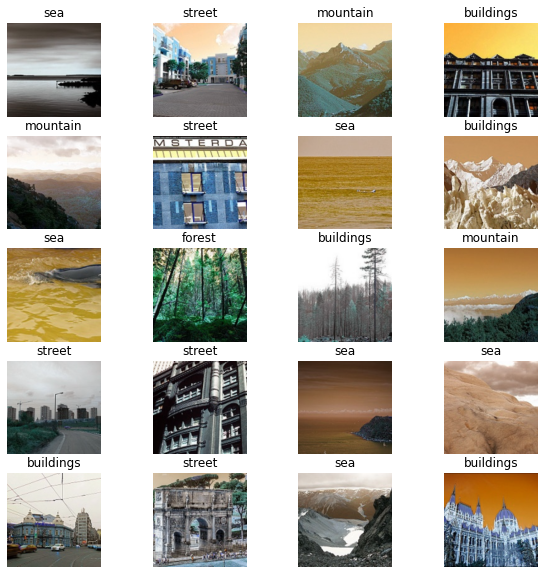

In [13]:
## four   layer CNN with scaled input .

##
model = tf.keras.models.Sequential([
    tf.keras.layers.experimental.preprocessing.Rescaling(1./255),
    tf.keras.layers.Conv2D( activation='relu', input_shape=(224, 224, 3),padding = 'same', filters = 64, kernel_size = 3),
    tf.keras.layers.MaxPooling2D(pool_size = (2,2), strides = (2, 2)), 
    tf.keras.layers.Dropout(0.2),
    tf.keras.layers.Conv2D( activation='relu', padding = 'same', filters = 64, kernel_size = 3),
    tf.keras.layers.MaxPooling2D(pool_size = (2,2), strides = (2, 2)), 
    tf.keras.layers.Dropout(0.2),
    tf.keras.layers.Conv2D( activation='relu', padding = 'same', filters = 128, kernel_size = 3),
    tf.keras.layers.MaxPooling2D(pool_size = (2,2), strides = (2, 2)), 
    tf.keras.layers.Dropout(0.2),
    tf.keras.layers.Conv2D( activation='relu', padding = 'same', filters = 256, kernel_size = 3),
    tf.keras.layers.MaxPooling2D(pool_size = (2,2), strides = (2, 2)), 
    tf.keras.layers.Dropout(0.2),
tf.keras.layers.Flatten(),
tf.keras.layers.Dense(128, activation=tf.nn.relu),
tf.keras.layers.Dense(6, activation=tf.nn.softmax)])


model.compile(optimizer='adam', loss='sparse_categorical_crossentropy', metrics=['accuracy'], )
%time history = model.fit(train_ds, epochs=10, validation_data = val_ds)
##
test_loss, test_acc = model.evaluate(test_ds)
print("Test image accuracy :{}".format(test_acc))
##
plt.plot(history.history['accuracy'], '-o' ,label='accuracy')
plt.plot(history.history['val_accuracy'], '-o', label = 'val_accuracy')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.ylim([0.5, 1])
plt.legend(loc='lower right')
##
model.save('model_cnn4')
##

## for validation data set , check the classification report.
val_pred = np.array([])
val_labels = np.array([])
for x, y in test_ds:
    predictions =  np.argmax(model.predict(x), axis = -1)
    val_pred = np.concatenate([val_pred,np.array(predictions)])
    val_labels = np.concatenate([val_labels , y.numpy()])
    
##
print('Classification Report')
target_names = class_names
print(classification_report(val_labels, val_pred, target_names=class_names))
##
print(model.summary())
##
pred_images_prediction = model.predict(pred_images)
##
pred_images_class = []
for i in range(len(pred_images_prediction)):
    pred_images_class.append(np.argmax(pred_images_prediction[i], axis = -1))
##
## visualize prediction images with the prediction 
plt.figure(figsize=(10, 10))
for i in range(20):
    ax = plt.subplot(5, 4, i + 1)
    plt.imshow(pred_images[i])
    plt.title(class_names[pred_images_class[i]])
    plt.axis("off")

Model accuracy has increased from 0.77 to 0.79 with another CNN +Max pooling layer.  
"Forest" has the best F1 score followed by "street","sea"and "glacier".  

Epoch 1/10
329/329 [==============================] - 165s 496ms/step - loss: 1.4608 - accuracy: 0.4197 - val_loss: 0.9673 - val_accuracy: 0.6556
Epoch 2/10
329/329 [==============================] - 163s 493ms/step - loss: 0.8452 - accuracy: 0.6648 - val_loss: 0.8020 - val_accuracy: 0.7058
Epoch 3/10
329/329 [==============================] - 162s 493ms/step - loss: 0.7116 - accuracy: 0.7340 - val_loss: 0.6327 - val_accuracy: 0.7597
Epoch 4/10
329/329 [==============================] - 163s 494ms/step - loss: 0.5818 - accuracy: 0.7857 - val_loss: 0.5975 - val_accuracy: 0.7728
Epoch 5/10
329/329 [==============================] - 163s 494ms/step - loss: 0.5045 - accuracy: 0.8206 - val_loss: 0.5796 - val_accuracy: 0.7873
Epoch 6/10
329/329 [==============================] - 162s 493ms/step - loss: 0.4571 - accuracy: 0.8333 - val_loss: 0.6079 - val_accuracy: 0.7805
Epoch 7/10
329/329 [==============================] - 163s 494ms/step - loss: 0.4003 - accuracy: 0.8582 - val_loss: 0.5040 -

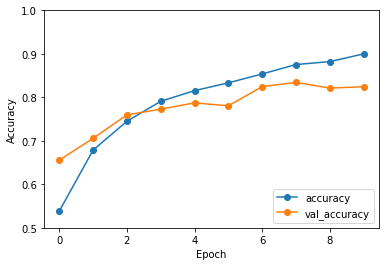

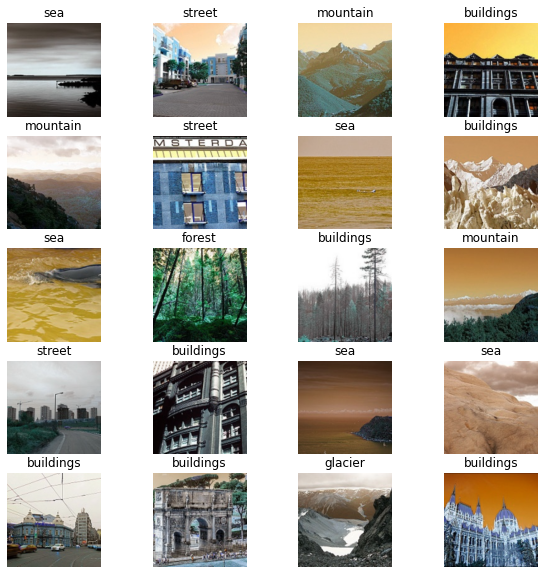

In [14]:
## 5 layer cnn + max pooling 
model = tf.keras.models.Sequential([
    tf.keras.layers.experimental.preprocessing.Rescaling(1./255),
    tf.keras.layers.Conv2D( activation='relu', input_shape=(224, 224, 3),padding = 'same', filters = 64, kernel_size = 3),
    tf.keras.layers.MaxPooling2D(pool_size = (2,2), strides = (2, 2)), 
    tf.keras.layers.Dropout(0.2),
    tf.keras.layers.Conv2D( activation='relu', padding = 'same', filters = 64, kernel_size = 3),
    tf.keras.layers.MaxPooling2D(pool_size = (2,2), strides = (2, 2)), 
    tf.keras.layers.Dropout(0.2),
    tf.keras.layers.Conv2D( activation='relu', padding = 'same', filters = 128, kernel_size = 3),
    tf.keras.layers.MaxPooling2D(pool_size = (2,2), strides = (2, 2)), 
    tf.keras.layers.Dropout(0.2),
    tf.keras.layers.Conv2D( activation='relu', padding = 'same', filters = 256, kernel_size = 3),
    tf.keras.layers.MaxPooling2D(pool_size = (2,2), strides = (2, 2)), 
    tf.keras.layers.Dropout(0.2),
    tf.keras.layers.Conv2D( activation='relu', padding = 'same', filters = 512, kernel_size = 3),
    tf.keras.layers.MaxPooling2D(pool_size = (2,2), strides = (2, 2)), 
    tf.keras.layers.Dropout(0.2),
tf.keras.layers.Flatten(),
tf.keras.layers.Dense(128, activation=tf.nn.relu),
tf.keras.layers.Dense(6, activation=tf.nn.softmax)])


model.compile(optimizer='adam', loss='sparse_categorical_crossentropy', metrics=['accuracy'], )
%time history = model.fit(train_ds, epochs=10, validation_data = val_ds)
##
test_loss, test_acc = model.evaluate(test_ds)
print("Test image accuracy :{}".format(test_acc))
##
plt.plot(history.history['accuracy'], '-o' ,label='accuracy')
plt.plot(history.history['val_accuracy'], '-o', label = 'val_accuracy')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.ylim([0.5, 1])
plt.legend(loc='lower right')
##
model.save('model_cnn5')
##

## for validation data set , check the classification report.
val_pred = np.array([])
val_labels = np.array([])
for x, y in test_ds:
    predictions =  np.argmax(model.predict(x), axis = -1)
    val_pred = np.concatenate([val_pred,np.array(predictions)])
    val_labels = np.concatenate([val_labels , y.numpy()])
    
##
print('Classification Report')
target_names = class_names
print(classification_report(val_labels, val_pred, target_names=class_names))
##
print(model.summary())
##
pred_images_prediction = model.predict(pred_images)
##
pred_images_class = []
for i in range(len(pred_images_prediction)):
    pred_images_class.append(np.argmax(pred_images_prediction[i], axis = -1))
##
## visualize prediction images with the prediction 
plt.figure(figsize=(10, 10))
for i in range(20):
    ax = plt.subplot(5, 4, i + 1)
    plt.imshow(pred_images[i])
    plt.title(class_names[pred_images_class[i]])
    plt.axis("off")

Model accuracy has increased from 0.79 to 0.8 with an addition of a CNN + Max Pooling layer.  
"Forest" has the best F1 score followed by "sea"and "street".  

Epoch 1/15
329/329 [==============================] - 164s 494ms/step - loss: 1.4445 - accuracy: 0.4966 - val_loss: 3.1430 - val_accuracy: 0.3563
Epoch 2/15
329/329 [==============================] - 163s 493ms/step - loss: 0.8503 - accuracy: 0.6615 - val_loss: 0.9620 - val_accuracy: 0.6574
Epoch 3/15
329/329 [==============================] - 163s 493ms/step - loss: 0.6682 - accuracy: 0.7636 - val_loss: 1.4081 - val_accuracy: 0.5556
Epoch 4/15
329/329 [==============================] - 162s 491ms/step - loss: 0.6225 - accuracy: 0.7703 - val_loss: 0.5967 - val_accuracy: 0.7876
Epoch 5/15
329/329 [==============================] - 162s 492ms/step - loss: 0.5530 - accuracy: 0.8010 - val_loss: 0.7586 - val_accuracy: 0.7346
Epoch 6/15
329/329 [==============================] - 162s 491ms/step - loss: 0.5311 - accuracy: 0.8077 - val_loss: 0.8463 - val_accuracy: 0.7032
Epoch 7/15
329/329 [==============================] - 162s 491ms/step - loss: 0.4615 - accuracy: 0.8309 - val_loss: 0.5781 -

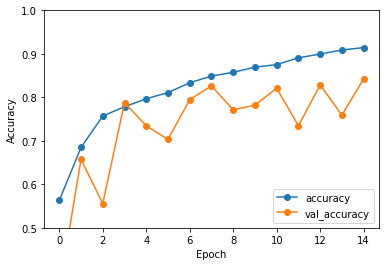

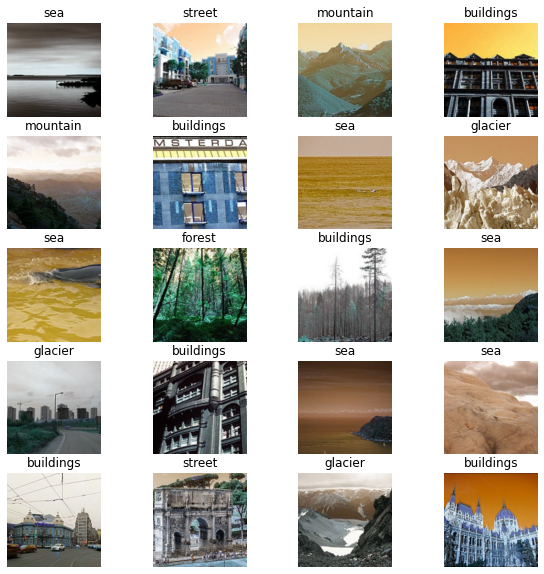

In [15]:
## 5 layer cnn + max pooling + batchnormalization
model = tf.keras.models.Sequential([
    tf.keras.layers.experimental.preprocessing.Rescaling(1./255),
    tf.keras.layers.Conv2D( activation='relu', input_shape=(224, 224, 3),padding = 'same', filters = 64, kernel_size = 3),
    tf.keras.layers.MaxPooling2D(pool_size = (2,2), strides = (2, 2)), 
    tf.keras.layers.Dropout(0.2),
    tf.keras.layers.Conv2D( activation='relu', padding = 'same', filters = 64, kernel_size = 3),
    tf.keras.layers.MaxPooling2D(pool_size = (2,2), strides = (2, 2)), 
    tf.keras.layers.Dropout(0.2),
    tf.keras.layers.Conv2D( activation='relu', padding = 'same', filters = 128, kernel_size = 3),
    tf.keras.layers.MaxPooling2D(pool_size = (2,2), strides = (2, 2)), 
    tf.keras.layers.Dropout(0.2),
    tf.keras.layers.Conv2D( activation='relu', padding = 'same', filters = 256, kernel_size = 3),
    tf.keras.layers.MaxPooling2D(pool_size = (2,2), strides = (2, 2)), 
    tf.keras.layers.Dropout(0.2),
    tf.keras.layers.Conv2D( activation='relu', padding = 'same', filters = 512, kernel_size = 3),
    tf.keras.layers.MaxPooling2D(pool_size = (2,2), strides = (2, 2)), 
    tf.keras.layers.Dropout(0.2),
    tf.keras.layers.BatchNormalization(),
tf.keras.layers.Flatten(),
tf.keras.layers.Dense(128, activation=tf.nn.relu),
tf.keras.layers.Dense(6, activation=tf.nn.softmax)])


model.compile(optimizer='adam', loss='sparse_categorical_crossentropy', metrics=['accuracy'], )
%time history = model.fit(train_ds, epochs=15, validation_data = val_ds)
##
test_loss, test_acc = model.evaluate(test_ds)
print("Test image accuracy :{}".format(test_acc))
##
plt.plot(history.history['accuracy'], '-o' ,label='accuracy')
plt.plot(history.history['val_accuracy'], '-o', label = 'val_accuracy')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.ylim([0.5, 1])
plt.legend(loc='lower right')
##
model.save('model_cnn5')
##

## for validation data set , check the classification report.
val_pred = np.array([])
val_labels = np.array([])
for x, y in test_ds:
    predictions =  np.argmax(model.predict(x), axis = -1)
    val_pred = np.concatenate([val_pred,np.array(predictions)])
    val_labels = np.concatenate([val_labels , y.numpy()])
    
##
print('Classification Report')
target_names = class_names
print(classification_report(val_labels, val_pred, target_names=class_names))
##
print(model.summary())
##
pred_images_prediction = model.predict(pred_images)
##
pred_images_class = []
for i in range(len(pred_images_prediction)):
    pred_images_class.append(np.argmax(pred_images_prediction[i], axis = -1))
##
## visualize prediction images with the prediction 
plt.figure(figsize=(10, 10))
for i in range(20):
    ax = plt.subplot(5, 4, i + 1)
    plt.imshow(pred_images[i])
    plt.title(class_names[pred_images_class[i]])
    plt.axis("off")

Model accuracy has increased from 0.8 to 0.83  with addition of BatchNormalization.  
"Forest" has the best F1 score followed by "street" and "sea".